<a href="https://colab.research.google.com/github/ianara01/Park-Sangjin/blob/master/GraphCN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install deepchem
import deepchem as dc

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 608 kB 5.3 MB/s 
     |████████████████████████████████| 29.5 MB 1.1 MB/s 


In [2]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Descriptors
from rdkit import DataStructs
import tensorflow as tf
from deepchem.models.layers import GraphConv, GraphPool, GraphGather
from deepchem.feat.mol_graphs import ConvMol
import tensorflow.keras.layers as layers
from deepchem.metrics import to_one_hot



# import tempfile
# from itertools import islice
# from IPython.display import Image, display
# from deepchem.utils.data_utils import load_from_disk  

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [3]:
!wget https://raw.githubusercontent.com/deepchem/deepchem/master/datasets/delaney-processed.csv

--2022-11-11 07:28:45--  https://raw.githubusercontent.com/deepchem/deepchem/master/datasets/delaney-processed.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 96699 (94K) [text/plain]
Saving to: ‘delaney-processed.csv’

delaney-processed.c 100%[===================>]  94.43K  --.-KB/s    in 0.01s   

2022-11-11 07:28:45 (6.46 MB/s) - ‘delaney-processed.csv’ saved [96699/96699]



In [4]:
dataset = pd.read_csv("delaney-processed.csv")
print(dataset.shape)
dataset[:3]

(1128, 10)


,Compound ID,ESOL predicted log solubility in mols per litre,Minimum Degree,Molecular Weight,Number of H-Bond Donors,Number of Rings,Number of Rotatable Bonds,Polar Surface Area,measured log solubility in mols per litre,smiles
0,Amigdalin,-0.974,1,457.432,7,3,7,202.32,-0.77,OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...
1,Fenfuram,-2.885,1,201.225,1,2,2,42.24,-3.30,Cc1occc1C(=O)Nc2ccccc2
2,citral,-2.579,1,152.237,0,0,4,17.07,-2.06,CC(C)=CCCC(C)=CC(=O)


In [5]:
tasks, datasets, transformers = dc.molnet.load_delaney(featurizer='ECFP')
train_dataset, valid_dataset, test_dataset = datasets

In [6]:
train_dataset

<DiskDataset X.shape: (902, 1024), y.shape: (902, 1), w.shape: (902, 1), ids: ['CC(C)=CCCC(C)=CC(=O)' 'CCCC=C' 'CCCCCCCCCCCCCC' ...
 'Nc2cccc3nc1ccccc1cc23 ' 'C1CCCCCC1' 'OC1CCCCCC1'], task_names: ['measured log solubility in mols per litre']>

In [7]:
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor()
dc_rfr = dc.models.SklearnModel(rfr)

#train_dataset에 포함된 X, w, y값을 사용하여 모델 훈련
dc_rfr.fit(train_dataset)

In [8]:
from deepchem.utils.evaluate import Evaluator
metric1 = dc.metrics.Metric(dc.metrics.r2_score)
metric2 = dc.metrics.Metric(dc.metrics.rms_score)

evaluator = Evaluator(dc_rfr, valid_dataset, transformers)
scores = evaluator.compute_model_performance([metric1, metric2])
print(scores)

{'r2_score': 0.16116069565379698, 'rms_score': 1.8105478992681483}


In [9]:
def rf_model_builder(n_estimators, max_features, max_depth, model_dir):
  rfr = RandomForestRegressor(
      n_estimators=n_estimators, max_features=max_features, max_depth=max_depth)
  return dc.models.SklearnModel(rfr, model_dir)

#하이퍼파라미터의 여러개의 값 설정 
params_dict = {
    "n_estimators": [50, 100],
    "max_features": [0.1, 0.15, 0.2],
    "max_depth" : [17, 19, 21]
}

metric = dc.metrics.Metric(dc.metrics.r2_score)
optimizer = dc.hyper.GridHyperparamOpt(rf_model_builder)

# 최고 성능의 모델, 최고 성능의 하이퍼파라미터, 모든 결과를 리턴한다
best_rf, best_rf_hyperparams, all_rf_results = optimizer.hyperparam_search(
    params_dict, train_dataset, valid_dataset, metric, transformers)

In [10]:
#최고 성능을 얻은 모델 하이퍼파라미터 출력
print(best_rf_hyperparams)
#모든 탐색 성능 평가 결과 출력
print(all_rf_results)

{'n_estimators': 50, 'max_features': 0.2, 'max_depth': 21}
{'_max_depth_17_max_features_0.100000_n_estimators_50': 0.24860532531067647, '_max_depth_19_max_features_0.100000_n_estimators_50': 0.23677123939022682, '_max_depth_21_max_features_0.100000_n_estimators_50': 0.21929414024615557, '_max_depth_17_max_features_0.150000_n_estimators_50': 0.2001369441880333, '_max_depth_19_max_features_0.150000_n_estimators_50': 0.22298454534758083, '_max_depth_21_max_features_0.150000_n_estimators_50': 0.22019348966858177, '_max_depth_17_max_features_0.200000_n_estimators_50': 0.18222310893472315, '_max_depth_19_max_features_0.200000_n_estimators_50': 0.25565483962072333, '_max_depth_21_max_features_0.200000_n_estimators_50': 0.26004024989757757, '_max_depth_17_max_features_0.100000_n_estimators_100': 0.24441163763666507, '_max_depth_19_max_features_0.100000_n_estimators_100': 0.22951582487063382, '_max_depth_21_max_features_0.100000_n_estimators_100': 0.23185450611942615, '_max_depth_17_max_feature

In [11]:
# 최대 성능값 찾기 (R2)
max(all_rf_results.values())

0.26004024989757757

In [12]:
# 딕셔너리에서 최대 value를 갖는 키 찾기
max(all_rf_results, key=all_rf_results.get)

'_max_depth_21_max_features_0.200000_n_estimators_50'

In [13]:
# Graph Convolution model 사용
tasks, datasets, transformers = dc.molnet.load_delaney(featurizer='GraphConv')
train_dataset, valid_dataset, test_dataset = datasets

In [14]:
train_dataset.X[0]

In [15]:
dc_gcn = dc.models.GraphConvModel(n_tasks=1, mode='regression', dropout=0.2)
dc_gcn.fit(train_dataset, nb_epoch=100)

0.11654919624328614

In [16]:
metric1 = dc.metrics.Metric(dc.metrics.mae_score)
metric2 = dc.metrics.Metric(dc.metrics.r2_score)
print("Training set score:", dc_gcn.evaluate(train_dataset, [metric1, metric2], transformers))
print("Test set score:", dc_gcn.evaluate(test_dataset, [metric1, metric2], transformers))

Training set score: {'mae_score': 0.5981262308092354, 'r2_score': 0.8670286001184809}
Test set score: {'mae_score': 1.1019443182939928, 'r2_score': 0.5676847635093928}


In [17]:
solubilities = dc_gcn.predict_on_batch(test_dataset.X)
for molecule, solubility, test_solubility in zip(test_dataset.ids, solubilities, test_dataset.y):
    print(solubility, test_solubility, molecule)

[-1.638554] [-1.60114461] c1cc2ccc3cccc4ccc(c1)c2c34
[0.5131849] [0.20848251] Cc1cc(=O)[nH]c(=S)[nH]1
[-0.5113548] [-0.01602738] Oc1ccc(cc1)C2(OC(=O)c3ccccc23)c4ccc(O)cc4 
[-1.8703533] [-2.82191713] c1ccc2c(c1)cc3ccc4cccc5ccc2c3c45
[-1.219398] [-0.52891635] C1=Cc2cccc3cccc1c23
[1.3345922] [1.10168349] CC1CO1
[-0.1682632] [-0.88987406] CCN2c1ccccc1N(C)C(=S)c3cccnc23 
[-0.9271637] [-0.52649706] CC12CCC3C(CCc4cc(O)ccc34)C2CCC1=O
[-0.78396773] [-0.76358725] Cn2cc(c1ccccc1)c(=O)c(c2)c3cccc(c3)C(F)(F)F
[0.01938855] [-0.64020358] ClC(Cl)(Cl)C(NC=O)N1C=CN(C=C1)C(NC=O)C(Cl)(Cl)Cl 
[-0.6141312] [-0.38569452] COc2c1occc1cc3ccc(=O)oc23 
[0.04885659] [-0.62568785] CN2C(=C(O)c1ccccc1S2(=O)=O)C(=O)Nc3ccccn3 
[-0.42643192] [-0.39585553] Cc3cc2nc1c(=O)[nH]c(=O)nc1n(CC(O)C(O)C(O)CO)c2cc3C
[-1.1283625] [-2.05306753] c1ccc(cc1)c2ccc(cc2)c3ccccc3
[-0.36328614] [-0.29666474] CC34CC(=O)C1C(CCC2=CC(=O)CCC12C)C3CCC4(=O) 
[-0.675376] [-0.73213651] c1ccc2c(c1)sc3ccccc23
[-0.44926536] [-1.27744393] CC23Cc1cnoc1C=

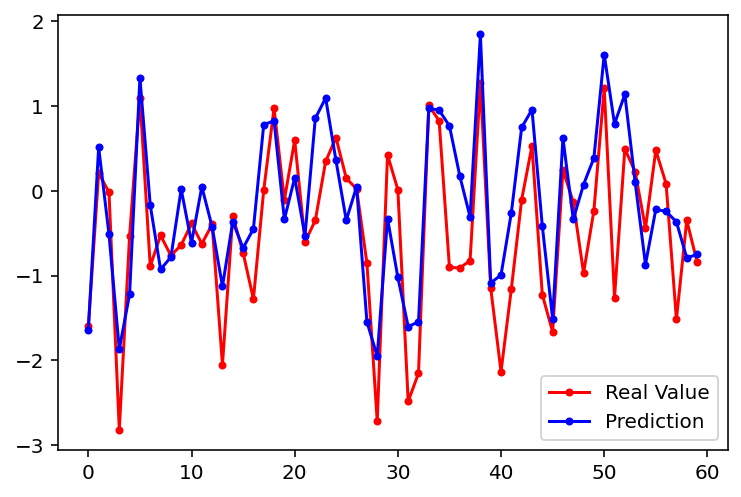

In [18]:
# 60개의 테스트 샘플만 비교했다
plt.plot(test_dataset.y[:60], "r.-", label='Real Value')
plt.plot(solubilities[:60], "b.-",  label='Prediction')
plt.legend()

In [19]:
smiles = ['COC(C)(C)CCCC(C)CC=CC(C)=CC(=O)OC(C)C',
          'CCOC(=O)CC',
          'CSc1nc(NC(C)C)nc(NC(C)C)n1',
          'CC(C#C)N(C)C(=O)Nc1ccc(Cl)cc1',
          'Cc1cc2ccccc2cc1C']
mols = [Chem.MolFromSmiles(s) for s in smiles]
featurizer = dc.feat.ConvMolFeaturizer()
x = featurizer.featurize(mols)
predicted_solubility = dc_gcn.predict_on_batch(x)
for m,s in zip(smiles, predicted_solubility):
    print()
    print('Molecule:', m)
    print('Predicted solubility:', s)


Molecule: COC(C)(C)CCCC(C)CC=CC(C)=CC(=O)OC(C)C
Predicted solubility: [-0.5225432]

Molecule: CCOC(=O)CC
Predicted solubility: [1.6750678]

Molecule: CSc1nc(NC(C)C)nc(NC(C)C)n1
Predicted solubility: [-0.12280745]

Molecule: CC(C#C)N(C)C(=O)Nc1ccc(Cl)cc1
Predicted solubility: [-0.43182015]

Molecule: Cc1cc2ccccc2cc1C
Predicted solubility: [-0.55234075]


In [20]:
x[1]

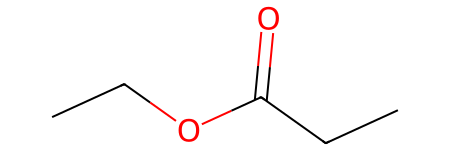

In [21]:
# 두번째 분자 보기
mol = Chem.MolFromSmiles("CCOC(=O)CC")
# for atom in mol.GetAtoms():
#   atom.SetAtomMapNum(atom.GetIdx())
mol

In [22]:
# ConvMol 특성의 구조 (원자가 7이고, 특성 벡터수가 75임)
x[1].atom_features.shape

(7, 75)

In [23]:
x[1].get_atom_features()

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0.

In [24]:
# 7개 원자의 인접 노드 번호들 보기
x[1].get_adjacency_list()

[[3], [6], [5], [0, 4], [3, 6], [6, 2], [4, 1, 5]]

In [25]:
# 분류 적용 예, tox21 data download
tasks, datasets, transformers = dc.molnet.load_tox21(featurizer='GraphConv')
train_dataset, valid_dataset, test_dataset = datasets

In [33]:
train_dataset

<DiskDataset X.shape: (6264,), y.shape: (6264, 12), w.shape: (6264, 12), task_names: ['NR-AR' 'NR-AR-LBD' 'NR-AhR' ... 'SR-HSE' 'SR-MMP' 'SR-p53']>

In [34]:
train_dataset.X

array([<deepchem.feat.mol_graphs.ConvMol object at 0x7f5bd505e090>,
       <deepchem.feat.mol_graphs.ConvMol object at 0x7f5bd53a97d0>, ...,
      dtype=object)

In [26]:
n_tasks = len(tasks)
model = dc.models.GraphConvModel(n_tasks, mode='classification')
model.fit(train_dataset, nb_epoch=50)
metric1 = dc.metrics.Metric(dc.metrics.roc_auc_score)
metric2 = dc.metrics.Metric(dc.metrics.accuracy_score)
print('Training set score:', model.evaluate(train_dataset, [metric1, metric2], transformers))
print('Test set score:', model.evaluate(test_dataset, [metric1, metric2], transformers))

Training set score: {'roc_auc_score': 0.970747989180785, 'accuracy_score': 0.8806007875691783}
Test set score: {'roc_auc_score': 0.695817704572435, 'accuracy_score': 0.7591411564625851}


In [27]:
#  GCN 구현
batch_size = 100

class MyGraphConvModel(tf.keras.Model):

  def __init__(self):
    super(MyGraphConvModel, self).__init__()
    self.gc1 = GraphConv(128, activation_fn=tf.nn.tanh)
    self.batch_norm1 = layers.BatchNormalization()
    self.gp1 = GraphPool()

    self.gc2 = GraphConv(128, activation_fn=tf.nn.tanh)
    self.batch_norm2 = layers.BatchNormalization()
    self.gp2 = GraphPool()

    self.dense1 = layers.Dense(256, activation=tf.nn.tanh)
    self.batch_norm3 = layers.BatchNormalization()
    self.readout = GraphGather(batch_size=batch_size, activation_fn=tf.nn.tanh)

    self.dense2 = layers.Dense(n_tasks*2)
    self.logits = layers.Reshape((n_tasks, 2))
    self.softmax = layers.Softmax()

  def call(self, inputs):
    gc1_output = self.gc1(inputs)
    batch_norm1_output = self.batch_norm1(gc1_output)
    gp1_output = self.gp1([batch_norm1_output] + inputs[1:])

    gc2_output = self.gc2([gp1_output] + inputs[1:])
    batch_norm2_output = self.batch_norm1(gc2_output)
    gp2_output = self.gp2([batch_norm2_output] + inputs[1:])

    dense1_output = self.dense1(gp2_output)
    batch_norm3_output = self.batch_norm3(dense1_output)
    readout_output = self.readout([batch_norm3_output] + inputs[1:])

    logits_output = self.logits(self.dense2(readout_output))
    return self.softmax(logits_output)

In [28]:
# 케라스 모델 사용
gcn_model = dc.models.KerasModel(MyGraphConvModel(), loss=dc.models.losses.CategoricalCrossEntropy())

In [29]:
# 입력은 ConvMol 타입임
test_dataset.X[0]

In [30]:
# X, y, w를 계속 자동으로 생성해주는 함수 정의
def data_generator(dataset, epochs=1):
  for ind, (X_b, y_b, w_b, ids_b) in enumerate(dataset.iterbatches(batch_size, 
              epochs, deterministic=False, pad_batches=True)):
    multiConvMol = ConvMol.agglomerate_mols(X_b)
    inputs = [multiConvMol.get_atom_features(), multiConvMol.deg_slice, 
              np.array(multiConvMol.membership)]
              
    for i in range(1, len(multiConvMol.get_deg_adjacency_lists())):
      inputs.append(multiConvMol.get_deg_adjacency_lists()[i])
    labels = [to_one_hot(y_b.flatten(), 2).reshape(-1, n_tasks, 2)]
    weights = [w_b]
    yield (inputs, labels, weights)

In [31]:
# from re import VERBOSE
gcn_model.fit_generator(data_generator(train_dataset, epochs=50))

0.23615798950195313

In [32]:
print('Training set score:', gcn_model.evaluate_generator(data_generator(train_dataset), [metric1, metric2], transformers))
print('Test set score:', gcn_model.evaluate_generator(data_generator(test_dataset), [metric1, metric2], transformers))

Training set score: {'roc_auc_score': 0.7953552366024281, 'accuracy_score': 0.8864814814814815}
Test set score: {'roc_auc_score': 0.6054619022225031, 'accuracy_score': 0.8473958333333332}
